In [92]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [93]:
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text

In [94]:
df_train = pd.read_csv('isear/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('isear/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('isear/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

In [ ]:
colors = np.array(["blue", 'gray', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(y_train.unique(),height=y_train.value_counts(), color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(y_test.unique(),height=y_test.value_counts(), color=colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(y_val.unique(),height=y_val.value_counts(), color=colors)
plt.title("Validation data - classes counts")
plt.show()


all_labels = pd.concat([y_train, y_test, y_val])

plt.bar(all_labels.unique(), height=all_labels.value_counts(), color=colors)
plt.title("Emotion dataset")
plt.show()
# 
all_data = pd.concat([df_train, df_val, df_test])
# emotion_counts = all_data['Emotion'].value_counts()
# colors = ['blue', 'gray', 'hotpink', 'gold', 'teal']
# 
# plt.bar(emotion_counts.index, height=emotion_counts, color=colors)
# plt.title('Emotion Distribution in the Combined Dataset')
# plt.xlabel('Emotion')
# plt.ylabel('Count')
# 
# # Show the plot
# plt.show()

combined_data = pd.concat([df_train, df_test, df_val])

train_counts = pd.crosstab(index=df_train['Emotion'], columns='count')
test_counts = pd.crosstab(index=df_test['Emotion'], columns='count')
validate_counts = pd.crosstab(index=df_val['Emotion'], columns='count')

merged_counts = pd.merge(train_counts, test_counts, left_index=True, right_index=True, suffixes=('_train', '_test'))
merged_counts = pd.merge(merged_counts, validate_counts, left_index=True, right_index=True)

ax = merged_counts.plot(kind='bar', stacked=False, figsize=(12, 6))

ax.set_title('Emotion Distribution Across Train, Test, and Validate Data')
ax.set_xlabel('Emotion')
ax.set_ylabel('Count')
ax.legend(title='Dataset')

plt.show()

In [96]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [97]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [98]:
path_to_glove_file = 'isear/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [99]:
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 256, 200)          3237000   
                                                                 
 bidirectional_24 (Bidirect  (None, 256, 512)          935936    
 ional)                                                          
                                                                 
 bidirectional_25 (Bidirect  (None, 256, 256)          656384    
 ional)                                                          
                                                                 
 bidirectional_26 (Bidirect  (None, 256)               394240    
 ional)                                                          
                                                                 
 dense_8 (Dense)             (None, 6)                 1542      
                                                      

In [100]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

In [101]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=256,
                    epochs=10,
                    callbacks=[callback]
                   )

Epoch 1/10
63/63 [==============================] - 752s 12s/step - loss: 1.5530 - accuracy: 0.3778 - val_loss: 1.3421 - val_accuracy: 0.5145
Epoch 2/10
63/63 [==============================] - 571s 9s/step - loss: 1.2310 - accuracy: 0.5466 - val_loss: 1.0598 - val_accuracy: 0.5895
Epoch 3/10
63/63 [==============================] - 599s 9s/step - loss: 0.9603 - accuracy: 0.6364 - val_loss: 0.6593 - val_accuracy: 0.7730
Epoch 4/10
63/63 [==============================] - 612s 10s/step - loss: 0.5075 - accuracy: 0.8225 - val_loss: 0.3438 - val_accuracy: 0.8810
Epoch 5/10
63/63 [==============================] - 624s 10s/step - loss: 0.3314 - accuracy: 0.8794 - val_loss: 0.4516 - val_accuracy: 0.8460
Epoch 6/10
63/63 [==============================] - 625s 10s/step - loss: 0.2943 - accuracy: 0.8956 - val_loss: 0.2321 - val_accuracy: 0.9070
Epoch 7/10
63/63 [==============================] - 637s 10s/step - loss: 0.1822 - accuracy: 0.9286 - val_loss: 0.2123 - val_accuracy: 0.9125
Epoch 8/

In [102]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 50s 784ms/step - loss: 0.1760 - accuracy: 0.9260


[0.17599695920944214, 0.9259999990463257]

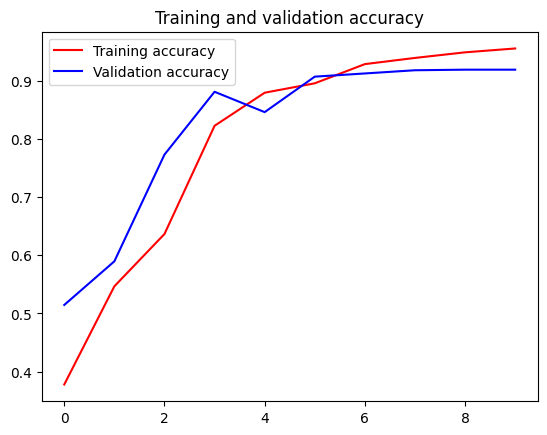

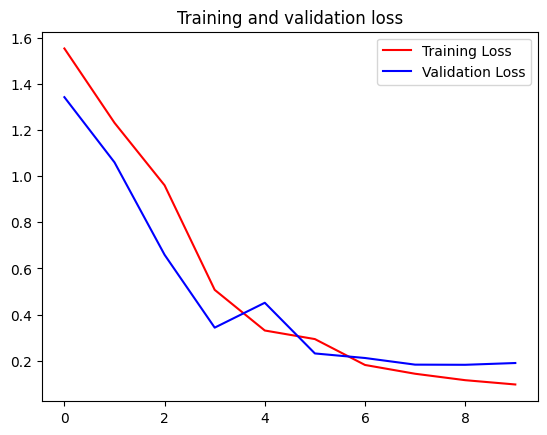

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [104]:
sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He's over the moon about being accepted to the university
1/1 [==============================] - 0s 284ms/step
joy : 0.9983600974082947


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 [==============================] - 0s 293ms/step
fear : 0.3815328776836395


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 [==============================] - 0s 290ms/step
sadness : 0.7260383367538452


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 [==============================] - 0s 290ms/step
surprise : 0.5778621435165405


In [105]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion_Recognition.keras')